# Notes to self
* VGG19 generalizes worse than VGG16. This could indicate VGG19 overfits, and that regularizing either VGG16 or VGG19 would increase performance. (Simpler models are better).
    * Inception performed even worse. More parameters leads to worse generalizability.


* Loading data using image-net preprocessing has to still be 128x128.
    * Bigger image not feasible, takes too much memory, and complicates model.
    

* Dropout doesnt seem to add any obvious performance for the VGG16, with dropout = 0.5

In [1]:
# Utilities
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import pandas as pd

import tensorflow as tf

# Keras
import keras
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception
from keras.preprocessing.image import ImageDataGenerator

# Visualization
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

# IPython
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Using TensorFlow backend.


In [2]:
def batch_evaluate_model(model, x, y, batch_size):
    """
        Evaluates a model by calculating the confusion matrix with precision and recall.
        This is done batch wise until the whole dataset (x and y) have been used for evaluation.
        
        param model: model to evaluate
        param x: input data
        param y: input labels
        param batch_size: batch size
        return: pandas dataframe representing a confusion matrix with precision and recall.
    """
    
    predictions = predict_batches(x, y, model, batch_size)[0]
    cmat = confusion_matrix(predictions, y)
    
    return precision_recall(cmat)

def predict_batches(x, y, model, batch_size):
    """
        Feeds the dataset (x and y) through the model batch wise, to get predictions for the whole dataset.
        This is to avoid having all the data in memory when passing it through the model, by doing it batch wise instead.
        This function returns all the predictions together with the correct predictions and incorrect predictions.
        
        param x: input data
        param y: input labels
        param model: model to use for predictions
        param batch_size: batch size
        return: All predictions, correct predictions, and incorrect predictions
    """
    x = x*(1./255)
    divisor = x.shape[0]//batch_size
    rest = x.shape[0]%batch_size
    all_predictions = np.around(model.predict_on_batch(x[:rest]))
    for batch_num in range(divisor):
        batch_startidx, batch_endidx = rest + (batch_num) * batch_size, rest + (batch_num + 1) * batch_size
        predictions = np.around(model.predict_on_batch(x[batch_startidx:batch_endidx]))
        all_predictions = np.concatenate((all_predictions, predictions))
    
    all_predictions = all_predictions.flatten()
    
    correct_classified = np.argwhere(all_predictions == y)[:,0]
    incorrect_classified = np.argwhere(all_predictions != y)[:,0]
    
    return all_predictions, correct_classified, incorrect_classified
    
    
def precision_recall(confmat):
    """
        Takes a confusion matrix and calculates the precision and recall metrics given the confusion matrix.
        
        param confmat: Confusion matrix to calculate precision and recall of.
        return: pandas dataframe representing a confusion matrix with precision and recall.
    """
    printmd("#### Confusion matrix")
    acc = np.trace(confmat)/np.sum(confmat)
    pr = [confmat[i,i]/sum(confmat[:,i]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    rc = [confmat[i,i]/sum(confmat[i,:]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    
    df = pd.DataFrame(confmat, columns=["acne", "rosacea"])#
    df = df.rename_axis("true labels")
    df = df.rename_axis("predictions", axis="columns")
    df.loc[-1] = [str(i)[:5] for i in pr]
    rcs = [str(i)[:5] for i in rc]
    rcs.append("")
    df["recall"] = rcs
    df.rename(index={0:"acne", 1:"rosacea", -1:"precision"}, inplace=True)#
    print("Test accuracy:", acc)
    return df

# Load dermatology data
The data is loaded from a numpy matrix compressed into an .npz file. This .npz file contains all the preprocessed data.

In [3]:
data = np.load("../data/data_matrix_128_derm101.npz")
X = data["X"].astype(np.uint8)
y = data["y"].astype(np.uint8)

N = X.shape[0]
D = X.shape[1:3]
C = X.shape[3]
K = 2
diagnosis = {0:"Acne", 1:"Rosacea"}

print("Total number of observations:", N)
print("Image dimensions:", D)
print("Number of image color channels:", C)
print("Number of classes:", K)
print("0: Acne, 1: Rosacea")


# 90% for training 10% for validation
train_idx = int(X.shape[0]*0.9)

x_train = X[:train_idx]
y_train = y[:train_idx]

x_val = X[train_idx:]
y_val = y[train_idx:]

print("Number of acne patients in training set:", len(y_train[y_train==0]))
print("Number of rosacea patients in training set:", len(y_train[y_train==1]))

print("Number of acne patients in validation set:", len(y_val[y_val==0]))
print("Number of rosacea patients in validation set:", len(y_val[y_val==1]))

Total number of observations: 2308
Image dimensions: (128, 128)
Number of image color channels: 3
Number of classes: 2
0: Acne, 1: Rosacea
Number of acne patients in training set: 583
Number of rosacea patients in training set: 1494
Number of acne patients in validation set: 73
Number of rosacea patients in validation set: 158


## Data augmentation

In [4]:
# Construct data generators that applies data augmentation (shear, zoom, flip, and normalization/rescale)
train_datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Model building

## Pre-trained bottom

In [5]:
# Load VGG16 with imagenet weigts, and exclude the dense top layers.
model_bottom = VGG16(weights="imagenet", include_top=False)

# freeze VGG16 weights for all its layers
for layer in model_bottom.layers:
    layer.trainable = False

# summary of the VGG16 convolutions
model_bottom.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Build on bottom (Transfer learning)

In [6]:
# create new input layer
#input_layer = keras.layers.Input(shape=x_train.shape[1:], name="image_input")
x = keras.layers.Input(shape=x_train.shape[1:], name="x")

# output from feature extraction of input
conv_features = model_bottom(x)

# fully connected layers
out = keras.layers.Flatten(name="flatten")(conv_features)
out = keras.layers.Dense(3, activation="relu", name="fully_connected1")(out)
out = keras.layers.Dropout(0.30)(out)
yhat = keras.layers.Dense(1, activation="sigmoid", name="yhat")(out)

# create model
model = keras.models.Model(inputs=x, outputs=yhat)

# optimizer
optimizer = keras.optimizers.adam(lr=0.001)

# compile model
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fully_connected1 (Dense)     (None, 3)                 24579     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
yhat (Dense)                 (None, 1)                 4         
Total params: 14,739,271
Trainable params: 24,583
Non-trainable params: 14,714,688
___________________________________________________________

# Training
During training, the model can in rare occasions get stuck at the baseline local minimum of around 68% for a long time. It usually escapes after around 35 epochs.

Epoch 1/100
29/29 [==============================] - 9s - loss: 0.5678 - acc: 0.7118 - val_loss: 0.5032 - val_acc: 0.6857
Epoch 2/100
29/29 [==============================] - 8s - loss: 0.4916 - acc: 0.7212 - val_loss: 0.4947 - val_acc: 0.6832
Epoch 3/100
29/29 [==============================] - 6s - loss: 0.4764 - acc: 0.7205 - val_loss: 0.4459 - val_acc: 0.7267
Epoch 4/100
29/29 [==============================] - 6s - loss: 0.4501 - acc: 0.7181 - val_loss: 0.3726 - val_acc: 0.7267
Epoch 5/100
29/29 [==============================] - 7s - loss: 0.4329 - acc: 0.7175 - val_loss: 0.4420 - val_acc: 0.7000
Epoch 6/100
29/29 [==============================] - 6s - loss: 0.4193 - acc: 0.7363 - val_loss: 0.4377 - val_acc: 0.7950
Epoch 7/100
29/29 [==============================] - 6s - loss: 0.4235 - acc: 0.7848 - val_loss: 0.4194 - val_acc: 0.8137
Epoch 8/100
29/29 [==============================] - 6s - loss: 0.4082 - acc: 0.7961 - val_loss: 0.4095 - val_acc: 0.7888
Epoch 9/100
29/29 [=====

### Performance evaluation

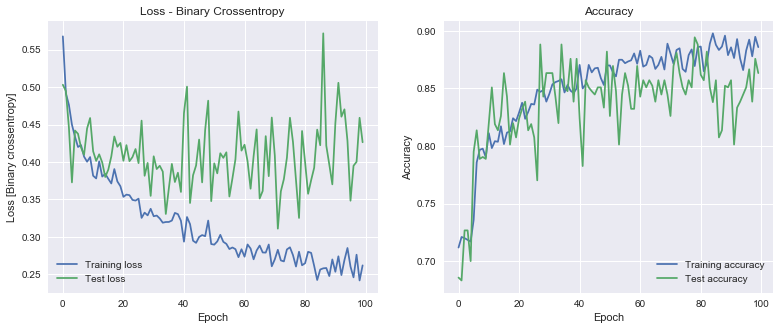

#### Confusion matrix

Test accuracy: 0.861471861472


predictions,acne,rosacea,recall
true labels,,,
acne,53,12,0.815
rosacea,20,146,0.879
precision,0.726,0.924,


In [7]:
batch_size = 70
epochs = 100

# Use data generators on input data.
train_gen = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_gen = test_datagen.flow(x_val, y_val, batch_size=batch_size)


# A quick model id for distinguishing models and performance
model_id = "-".join([model_bottom.name,
                     "fc"+str(len(model.layers[3:])-1),
                     "drop30",
                     model.loss.split("_")[0],
                     "epoch"+str(epochs),
                     "batch"+str(batch_size)])

# Callback to Tensorboard for graph visualization
tensorboard = keras.callbacks.TensorBoard(log_dir='tb_logs/'+model_id, histogram_freq=0,
                            write_graph=True, write_images=True)

# Train model using the batch generators with augmented data.
hist = model.fit_generator(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[tensorboard],
                           steps_per_epoch=x_train.shape[0]//batch_size, validation_steps=x_val.shape[0]//batch_size)

# Save model
model.save("saved_models/" + model_id)


# Performance evalutation
printmd("### Performance evaluation")
# Plot accuracy
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
ax1.plot(hist.history['loss'], label="Training loss")
ax1.plot(hist.history['val_loss'], label="Test loss")
ax1.set_title("Loss - Binary Crossentropy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss [Binary crossentropy]")
ax2.plot(hist.history["acc"], label="Training accuracy")
ax2.plot(hist.history["val_acc"], label="Test accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax1.legend()
ax2.legend()
plt.show()

# Confusion matrix with precision and recall
batch_evaluate_model(model, x_val, y_val, batch_size)

##### NOTES*
* Hard to evaluate the specific performance in terms of accuracy, since it fluctuates a lot. It most like fluctuates a lot because specific pictures have about even probability of each class, leading to the model guessing specific pictures.

# Loading an old model and its performance

In [10]:
# load a model
model = keras.models.load_model("saved_models/vgg16-fc2-drop30-binary-epoch100-batch70")
batch_size = 70

In [11]:
# Confusion matrix with precision and recall
batch_evaluate_model(model, x_val, y_val, batch_size=batch_size)

#### Confusion matrix

Test accuracy: 0.861471861472


predictions,acne,rosacea,recall
true labels,,,
acne,53,12,0.815
rosacea,20,146,0.879
precision,0.726,0.924,
